In [52]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

pd.set_option("display.max_columns",150)


In [64]:
all_data = pd.read_csv("telco-customer-churn.csv")

print (all_data.shape)

for col_name in all_data.columns.values:
    all_unique = all_data[col_name].unique()
    print (col_name, len(all_unique), all_unique[0:5])

(20468, 29)
age 68 [12 42 58 20 36]
annualincome 9508 [168147  29047  27076 137977 136006]
calldroprate 8 [ 0.06  0.05  0.07  0.    0.01]
callfailurerate 4 [ 0.    0.01  0.02  0.03]
callingnum 9525 [4251078442 4251043419 4251055773 4251042488 4251073177]
customerid 9525 [1 2 3 4 5]
customersuspended 2 ['Yes' 'No']
education 4 ['Bachelor or equivalent' 'Master or equivalent' 'PhD or equivalent'
 'High School or below']
gender 2 ['Male' 'Female']
homeowner 2 ['Yes' 'No']
maritalstatus 2 ['Single' 'Married']
monthlybilledamount 120 [71  8 16 74 81]
noadditionallines 1 ['\\N']
numberofcomplaints 4 [0 1 3 2]
numberofmonthunpaid 8 [7 4 2 5 0]
numdayscontractequipmentplanexpiring 100 [96 14 55 73 32]
occupation 3 ['Technology Related Job' 'Non-technology Related Job' 'Others']
penaltytoswitch 500 [371  43 403  76 436]
state 50 ['WA' 'WI' 'KS' 'KY' 'ND']
totalminsusedinlastmonth 500 [ 15 212 216 412 416]
unpaidbalance 250 [ 19  34 144 159 143]
usesinternetservice 2 ['No' 'Yes']
usesvoiceservic

In [65]:
def plot_col (col_name):
    dt_plot = all_data.groupby(col_name).agg({'age':'count', 'churn': 'sum'}).reset_index().rename(columns={'age':'rec_count'})
    dt_plot['churn_perc'] = dt_plot['churn'] / dt_plot['rec_count']
    print (dt_plot.head())

    plt.plot(dt_plot[col_name],dt_plot['churn_perc'])
    plt.show()


   callfailurerate  rec_count  churn  churn_perc
0             0.00       4956    456    0.092010
1             0.01       5191    439    0.084569
2             0.02       4963    481    0.096917
3             0.03       5358    487    0.090892


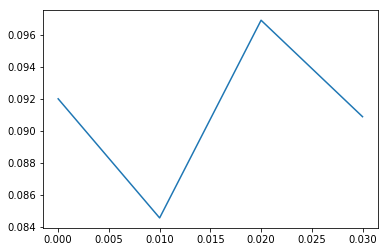

In [66]:
plot_col('callfailurerate')

Удаляем колонки с годом, месяцев и номером телефона. Они не должны влиять на уровень churn. Но будем иметь в виду, что данные для каждого номера даны за несколько месяцев.

In [67]:
all_data.drop(['year','month','callingnum','customerid','noadditionallines'],axis=1,inplace=True)

In [69]:
bin_cols = ['customersuspended','gender','homeowner','maritalstatus','usesinternetservice','usesvoiceservice']
for col_name in bin_cols:
    unique_val = all_data[col_name].unique()[0]
    all_data[col_name+"__"+unique_val] = 0
    all_data.loc[all_data[col_name]==unique_val,col_name+"__"+unique_val] = 1
    all_data.drop(col_name, axis = 1, inplace=True)